In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sys
sys.path.append('..')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
WIN = 'D:/'
MAC = '/Volumes/Transcend2/17_20_PhD/19_20_PhD_Metabolomics/'

osp = MAC

## 1. Load aligned peaksets

In [24]:
output_dir = osp+'/pymz/mzmine/peak_picked_files/samples_alignment/'

In [25]:
all_df = pd.read_csv(output_dir+'pp_aligned.csv', index_col=0)
feature_description = all_df.iloc[:,:2]
all_samples = all_df.iloc[:,2:-1]
all_samples.columns = [x.split(" ")[0] for x in list(all_samples.columns)]

## 2. Label samples

In [7]:
condition = []
dataset = []
for name in np.array(all_samples.columns):
    value = name.split('.')[0].split('_')[0][0]
    value2 = name.split('.')[0].split('_')[0][0]
    
    if (value == 'C' and len(name.split('.')[0].split('_')) == 2 and name.split('.')[0].split('_')[1] == '2'):
        condition.append('control')
        dataset.append('VL')
    elif  (value == 'C'):   
        condition.append('control')
        dataset.append('Zika')
    elif (value == 'Z'):
        condition.append('infected')
        dataset.append('Zika')
    elif (value[0] == 'V'):
        condition.append('infected')
        dataset.append('VL')
        
    elif (value == 'K' and int(name.split('.')[0].split('_')[1])%3 == 1 ):
        condition.append('control')
        dataset.append('Malaria')
    else:
        condition.append('infected')
        dataset.append('Malaria')
        

In [8]:
sample_description = pd.DataFrame(data=[list(all_samples.columns),condition,dataset] )
sample_description = sample_description.transpose()
sample_description.columns = ['Sample Name', 'Condition', 'Dataset']
sample_description["ConditionDataset"] = sample_description["Condition"]+sample_description["Dataset"]

## 3. Log transformation

In [9]:
all_samples_log = np.log2(all_samples+1)
print('Total number of peaksets: {}'.format(len(all_samples_log)))

Total number of peaksets: 37220


In [ ]:
all_samples_log.plot.density(legend = False)

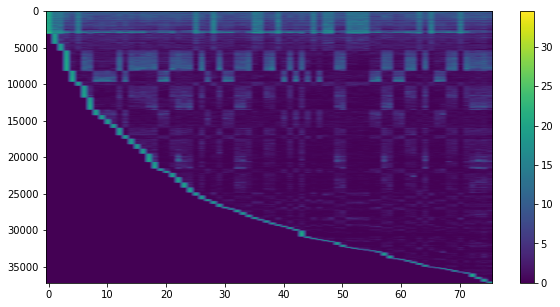

In [10]:
plt.figure(figsize=(10,5))
plt.imshow(all_samples_log,aspect='auto')
plt.colorbar()
plt.show()

## 4. PCA plot

In [11]:
# rearranging the dataframe
Zik = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'Zika')].transpose()
zik_con = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "Zika"]['Condition'] =="control")].transpose()
zik_inf = Zik.transpose()[np.array(sample_description[sample_description["Dataset"] == "Zika"]['Condition'] =="infected")].transpose()
Mal = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'Malaria')].transpose()
mal_con = Mal.transpose()[np.array(sample_description[sample_description["Dataset"] == "Malaria"]['Condition'] =="control")].transpose()
mal_inf = Mal.transpose()[np.array(sample_description[sample_description["Dataset"] == "Malaria"]['Condition'] =="infected")].transpose()
vl = all_samples_log.transpose()[np.array(sample_description['Dataset'] == 'VL')].transpose()
vl_con = vl.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="control")].transpose()
vl_inf = vl.transpose()[np.array(sample_description[sample_description["Dataset"] == "VL"]['Condition'] =="infected")].transpose()

In [12]:
pdList = [vl_inf,vl_con,zik_inf, zik_con, mal_inf,mal_con]  
all_samples_log_rearanged = pd.concat(pdList, axis = 1)

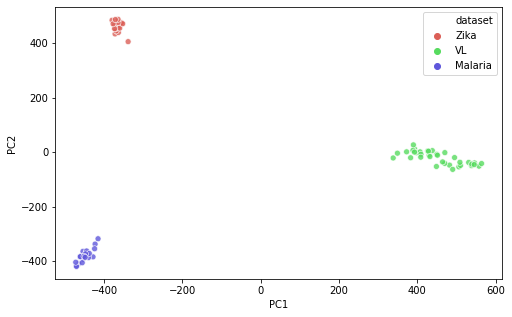

In [13]:
from sklearn.decomposition import PCA
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(8,5))
sns.scatterplot(x="PC1", y="PC2",hue="dataset",
    palette=sns.color_palette("hls", 3),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

## 5. Filtering

In [19]:
from metab_utils import get_ids_for_top_percent
idzik = get_ids_for_top_percent(Zik, 50)
idmal = get_ids_for_top_percent(Mal, 50)
idvl = get_ids_for_top_percent(vl, 50)
inters = set(idzik) & set(idmal) & set(idvl)
print('Total number of peaksets remaining after filtering: {}'.format(len(inters)))

Total number of peaksets remaining after filtering: 604


In [20]:
all_samples_log_filtered = all_samples_log.loc[list(inters)]

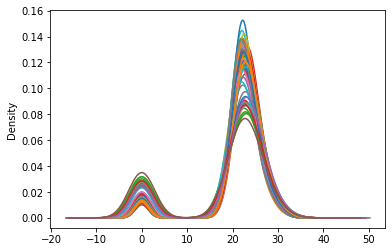

In [21]:
all_samples_log_filtered.plot.density(legend=False)

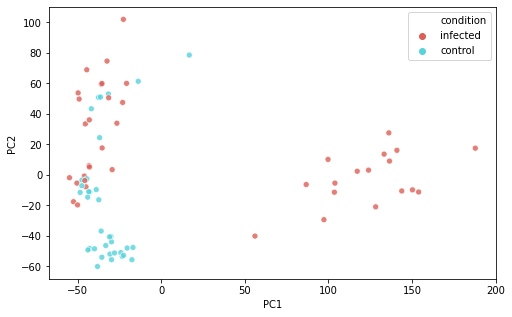

In [23]:
pca_samples = PCA(n_components=3)

principalComponents = pca_samples.fit_transform(all_samples_log_filtered.transpose())
principalComponents_df = pd.DataFrame(data = principalComponents, columns= ['PC1','PC2', 'PC3'])
principalComponents_df['condition'] = list(sample_description['Condition'])
principalComponents_df['dataset'] = list(sample_description['Dataset'])

plt.figure(figsize=(8,5))
sns.scatterplot(x="PC1", y="PC2",hue="condition",
    palette=sns.color_palette("hls", 2),
    data=principalComponents_df,
    legend="full",
    alpha=0.8
)

## 6. Imputing missing values with KNN

In [44]:
all_samples_log_filtered_na = all_samples_log_filtered.copy()
all_samples_log_filtered_na.replace(0, np.nan, inplace = True)

In [45]:
from metab_utils import impute_knn
sample_values = all_samples_log_filtered_na
zik_con_filled = impute_knn(sample_values, list(zik_con.columns))
zik_inf_filled = impute_knn(sample_values, list(zik_inf.columns))
vl_con_filled = impute_knn(sample_values, list(vl_con.columns))
vl_inf_filled = impute_knn(sample_values, list(vl_inf.columns))
mal_con_filled = impute_knn(sample_values, list(mal_con.columns))
mal_inf_filled = impute_knn(sample_values, list(mal_inf.columns))

Imputing row 1/604 with 0 missing, elapsed time: 0.077
Imputing row 101/604 with 0 missing, elapsed time: 0.082
Imputing row 201/604 with 0 missing, elapsed time: 0.085
Imputing row 301/604 with 0 missing, elapsed time: 0.088
Imputing row 401/604 with 0 missing, elapsed time: 0.090
Imputing row 501/604 with 2 missing, elapsed time: 0.093
Imputing row 601/604 with 3 missing, elapsed time: 0.096
Imputing row 1/604 with 0 missing, elapsed time: 0.074
Imputing row 101/604 with 0 missing, elapsed time: 0.076
Imputing row 201/604 with 0 missing, elapsed time: 0.078
Imputing row 301/604 with 0 missing, elapsed time: 0.080
Imputing row 401/604 with 0 missing, elapsed time: 0.082
Imputing row 501/604 with 2 missing, elapsed time: 0.085
Imputing row 601/604 with 2 missing, elapsed time: 0.088
Imputing row 1/604 with 0 missing, elapsed time: 0.087
Imputing row 101/604 with 0 missing, elapsed time: 0.102
Imputing row 201/604 with 0 missing, elapsed time: 0.107
Imputing row 301/604 with 0 missing, 

In [46]:
pdList = [vl_inf_filled,vl_con_filled,zik_inf_filled, zik_con_filled, mal_inf_filled,mal_con_filled]  
all_samples_log_filtered_filled = pd.concat(pdList, axis = 1)
all_samples_log_filtered_filled = all_samples_log_filtered_filled[list(all_samples_log.columns)]

## 7. Export data (Skip this step now)

In [18]:
#filtered values without missing values imputed
all_samples_log_filtered.to_csv(osp+'pymz/mzmine/221119/all_samples_log2_filtered.csv', header=True, index=True, sep=',', mode='w')
#filtered values with missing values imputed
all_samples_log_filtered_filled.to_csv(osp+'pymz/mzmine/221119/all_samples_log2_filtered_filled.csv', header=True, index=True, sep=',', mode='w')
#pheno data
sample_description.to_csv(osp+'pymz/mzmine/221119/sample_description.csv', header=True, index=None, sep=',', mode='w')
feature_description.to_csv(osp+'pymz/mzmine/221119/feature_description.csv', header=True, index=True, sep=',', mode='w')
                           
                           

In [20]:
filtered_samples = all_samples_log_filtered.copy()
filtered_samples = filtered_samples.transpose()
filtered_samples["Condition"] = np.array(sample_description["Condition"])
filtered_samples["Dataset"] = np.array(sample_description["Dataset"])
filtered_samples['ConditionDataset'] = np.array(sample_description['ConditionDataset'])
filtered_samples.to_csv(osp+'pymz/mzmine/221119/modifiedRTfiltereddata.txt', header=True, index=True, sep='\t', mode='w')

## 8. Limma analysis in R

In [47]:
all_samples_log_filtered_file = output_dir + 'all_samples_log_filtered.csv'
sample_description_file = output_dir + 'sample_description.csv'
all_samples_log_filled_file = output_dir + 'all_samples_log_filtered_filled.csv'


all_samples_log_filtered.to_csv(all_samples_log_filtered_file, header=True, index=True, sep=',', mode='w')
sample_description.to_csv(sample_description_file, header=True, index=None, sep=',', mode='w')
all_samples_log_filtered_filled.to_csv(all_samples_log_filled_file, header=True, index=True, sep=',', mode='w')

In [27]:
%load_ext rpy2.ipython

In [28]:
%%R

library(limma)
library(Biobase)

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following object is masked from ‘package:limma’:

    plotMA


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, 

In [49]:
file_to_be_analysed = all_samples_log_filled_file

In [50]:
%%R -i file_to_be_analysed -i sample_description_file


eset = readExpressionSet(file_to_be_analysed, sample_description_file, 
                         exprsArgs=list(sep=",", header=TRUE,quote="",row.names = 1),
                         phenoDataArgs=list(sep=",", header=TRUE,quote=""))

edata = exprs(eset)
pheno = pData(eset)

#creating the levels for the Condition and Dataset in pData
levels(pheno$Condition) = c('control','infected')
levels(pheno$Dataset)  = c('Malaria', 'VL', 'Zika')
pData(eset) = pheno

In [51]:
limma_table_file = output_dir + 'limma_independent_toptable_filled.csv'

In [52]:
%%R -i limma_table_file

eset.dataset = factor(as.character(pData(eset)$Dataset))
eset.condition = factor(as.character(pData(eset)$Condition))

eset.design = model.matrix(~ 0 + eset.condition + eset.dataset)
eset.fit = lmFit(eset, eset.design)


#define the contrasts you want to make, estimate the coefficients 
#and std errs for these contrasts, eBayes moderation of std errs.
contr = makeContrasts(eset.conditioninfected - eset.conditioncontrol, levels=colnames(coef(eset.fit)))
eset.fit = contrasts.fit(eset.fit, contr)
eset.fit = eBayes(eset.fit)

#Extract results per metabolite
top.table = topTable(eset.fit, sort.by="p", n=Inf)
write.csv(top.table, file = limma_table_file, sep = ",", quote = FALSE)

In [53]:
limma_table = pd.read_csv(limma_table_file, sep=',')
limma_table.index = limma_table[limma_table.columns[0]]
del limma_table[(limma_table.columns[0])]

In [54]:
print("The number of significantly different metabolites is:",len(limma_table[limma_table['adj.P.Val'] < 0.05]))

The number of significantly different metabolites is: 275


In [55]:
data = feature_description.loc[limma_table.index]
data['adj-p'] = limma_table['adj.P.Val']
data['t-val'] = limma_table['t']
data['custom_id'] = list(data.index)

In [56]:
data.to_csv(output_dir+'limma_independent_toptable_filled_features.csv', header=True, index=None, sep=',', mode='w')

In [42]:
data

,row m/z,row retention time,adj-p,t-val,custom_id
Unnamed: 0,,,,,
633,148.073458,11.915377,1.707271e-07,-7.230248,633
613,147.076407,11.905214,1.707271e-07,-7.050995,613
3109,905.593771,2.998939,1.707271e-07,-7.048608,3109
2989,810.600011,3.171275,3.354703e-07,-6.773560,2989
324,126.021981,12.209536,3.354703e-07,-6.770043,324
...,...,...,...,...,...
1982,257.113047,8.046586,9.784447e-01,-0.035265,1982
240,118.086244,9.607425,9.792079e-01,-0.032271,240
2037,264.180478,3.470832,9.818751e-01,0.026886,2037
